# Section-01

## Imports & Configuration

In [47]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Global constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
DATA_DIR = "PlantVillage"
MODEL_DIR = "../saved_models"

## Dataset Preparation

In [48]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("Classes:", class_names)

# Partition dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2152 files belonging to 3 classes.
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## Data Augmentation & Preprocessing

In [49]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

## Model Definition

In [50]:
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

## Compile & Train

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6603 - loss: 1.0058 - val_accuracy: 0.8385 - val_loss: 0.5093
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8322 - loss: 0.4239 - val_accuracy: 0.7969 - val_loss: 0.4306
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8692 - loss: 0.3224 - val_accuracy: 0.8490 - val_loss: 0.3471
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9115 - loss: 0.2222 - val_accuracy: 0.9323 - val_loss: 0.1776
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9248 - loss: 0.2055 - val_accuracy: 0.9271 - val_loss: 0.2232
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9334 - loss: 0.1738 - val_accuracy: 0.9688 - val_loss: 0.1209
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9444 - loss: 0.1476 - val_accuracy: 0.8958 - val_loss: 0.2240
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9572 - loss: 0.1325 - val_accuracy: 0.9271 - val_l

## Evaluation

In [52]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.9688 - loss: 0.0862
Test Accuracy: 0.97, Test Loss: 0.09


## Training Curves

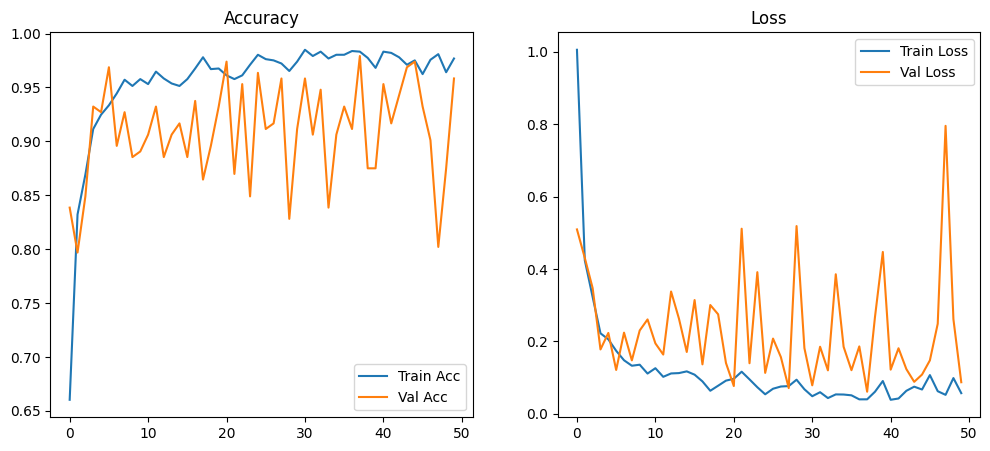

In [53]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(acc, label='Train Acc'); ax1.plot(val_acc, label='Val Acc')
ax1.legend(); ax1.set_title("Accuracy")

ax2.plot(loss, label='Train Loss'); ax2.plot(val_loss, label='Val Loss')
ax2.legend(); ax2.set_title("Loss")
plt.show()

## Save Model with Versioning

In [54]:
os.makedirs(MODEL_DIR, exist_ok=True)

# Auto-increment version
existing_versions = [int(os.path.splitext(f)[0]) for f in os.listdir(MODEL_DIR) if f.endswith(".keras") and os.path.splitext(f)[0].isdigit()]
model_version = max(existing_versions + [0]) + 1

save_path = os.path.join(MODEL_DIR, f"{model_version}.keras")
model.save(save_path)
print(f"Model saved at {save_path}")

Model saved at ../saved_models\1.keras


## Export to `.h5` file so that, we can upload to GCP conveniently

In [55]:
# Ensure directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Auto-increment version for .h5 files
existing_h5_versions = [
    int(os.path.splitext(f)[0].replace("models", ""))
    for f in os.listdir(MODEL_DIR)
    if f.startswith("models") and f.endswith(".h5") and os.path.splitext(f)[0].replace("models", "").isdigit()
]

h5_version = max(existing_h5_versions + [0]) + 1
h5_save_path = os.path.join(MODEL_DIR, f"models{h5_version}.h5")

# Save model
model.save(h5_save_path)
print(f"Model also exported as {h5_save_path}")

Model also exported as ../saved_models\models1.h5


---

# Section-02